In [1]:
from model import RNNModel
from trainer import Trainer
from utils import get_config
import tensorflow as tf
import os
import brackets
import numpy as np
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
config = get_config('./configs/lstm-64.json')

model = RNNModel(config)

sess = tf.Session()
sess.run([
    tf.global_variables_initializer(),
    tf.local_variables_initializer(),
    tf.tables_initializer()
])

model.load(sess)
trainer = Trainer(sess, model, config)

/home/filip/.conda/envs/tf35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading model checkpoint ./experiments/lstm-64/checkpoints/lstm-64-120001 ...



In [3]:
def validate_by_size(trainer, ns, size=1000):
    losses = []
    losses_cls = []
    accs = []
    accs_cls = []
    for i in ns:
        bs = np.array([brackets.random_bracket_joined(i) for _ in range(size)])
        stats = np.array([brackets.statistics(b) for b in bs])
        preds, _, acc, loss = trainer.predict(bs, stats)
        accs.append(np.mean(acc))
        losses.append(loss)
        accs_cls.append(acc)
        losses_cls.append(((stats - preds)**2).mean(axis=0))
    return losses, losses_cls, accs, accs_cls

In [4]:
losses, losses_cls, accs, accs_cls,  = validate_by_size(trainer, range(1, 100))

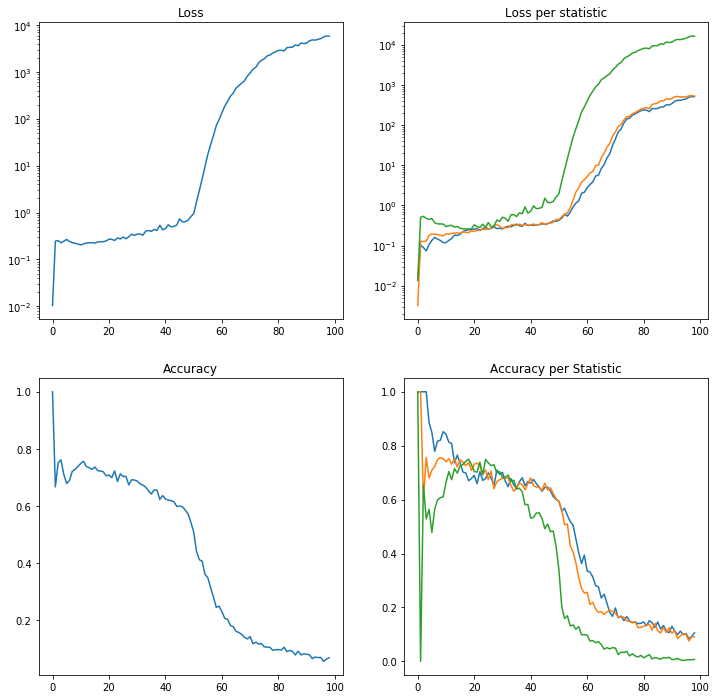

In [5]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Loss")
plt.yscale('log')
plt.plot(losses)

plt.subplot(2, 2, 2)
plt.title("Loss per statistic")
plt.yscale('log')
plt.plot(losses_cls)

plt.subplot(2, 2, 3)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(2, 2, 4)
plt.title("Accuracy per Statistic")
plt.plot(accs_cls)

plt.show()

In [6]:
def validate_by_ground_truth(trainer, max_len, n=1000, batch_size=32):

    ps = [[[], [], []] for _ in range(max_len*2+1)]
    rs = [[[], [], []] for _ in range(max_len*2+1)]

    for _ in range(n):
        data_x, data_y = brackets.next_batch(32, max_len)
        preds, rounded, _, _, = trainer.predict(data_x, data_y)
        
        for p, r, y in zip(preds, rounded, data_y):
            ps[y[0]][0].append(p[0])
            ps[y[1]][1].append(p[1])
            ps[y[2]][2].append(p[2])
            rs[y[0]][0].append(r[0])
            rs[y[1]][1].append(r[1])
            rs[y[2]][2].append(r[2])
            
    mse = lambda scalar, l: ((np.array(l) - scalar)**2).mean() if l else -1
    ac = lambda scalar, l: l.count(scalar) / len(l) if l.count(scalar) > 0 else -1
    
    loss1 = [mse(i, x) for i, (x, _, _) in enumerate(ps[1:], 1)]
    loss2 = [mse(i, x) for i, (_, x, _) in enumerate(ps[1:], 1)]
    loss3 = [mse(i, x) for i, (_, _, x) in enumerate(ps[1:], 1)]
    
    acc1 = [ac(i, x) for i, (x, _, _) in enumerate(rs[1:], 1)]
    acc2 = [ac(i, x) for i, (_, x, _) in enumerate(rs[1:], 1)]
    acc3 = [ac(i, x) for i, (_, _, x) in enumerate(rs[1:], 1)]
    
    return (loss1, loss2, loss3), (acc1, acc2, acc3)

In [7]:
loss, acc = validate_by_ground_truth(trainer, 100)

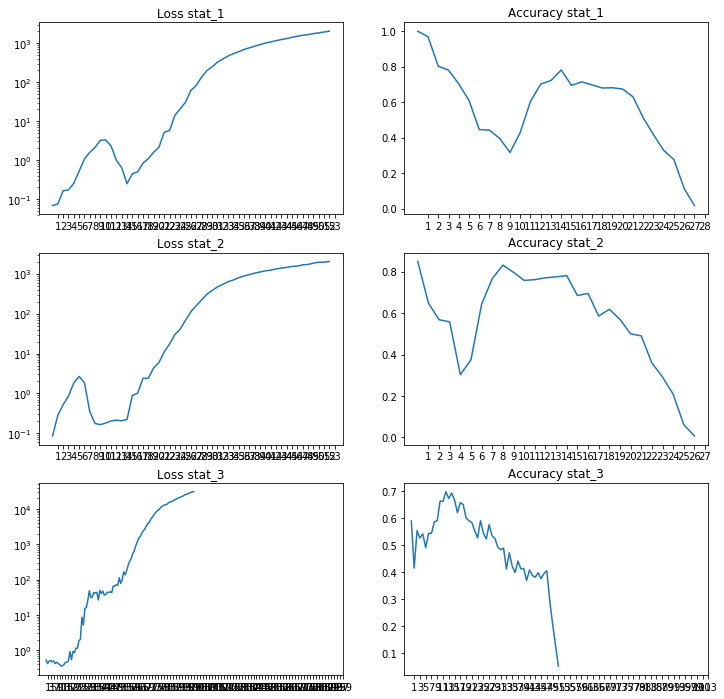

In [8]:
def clean(stat):
    cleaned = []
    xs = []
    
    for i, x in enumerate(stat, 1):
        if x > 0:
            cleaned.append(x)
            xs.append(i)
     
    return cleaned, xs


plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.title("Loss stat_1")
plt.yscale('log')
y, x = clean(loss[0])
plt.plot(y)
plt.xticks(x)

plt.subplot(3, 2, 3)
plt.title("Loss stat_2")
plt.yscale('log')
y, x = clean(loss[1])
plt.plot(y)
plt.xticks(x)

plt.subplot(3, 2, 5)
plt.title("Loss stat_3")
plt.yscale('log')
y, x = clean(loss[2])
plt.plot(y)
plt.xticks(x)

plt.subplot(3, 2, 2)
plt.title("Accuracy stat_1")
y, x = clean(acc[0])
plt.plot(y)
plt.xticks(x)

plt.subplot(3, 2, 4)
plt.title("Accuracy stat_2")
y, x = clean(acc[1])
plt.plot(y)
plt.xticks(x)

plt.subplot(3, 2, 6)
plt.title("Accuracy stat_3")
y, x = clean(acc[2])
plt.plot(y)
plt.xticks(x)
plt.show()
